In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from dis2p import dis2pvi_cE as dvi
# from dis2p_reproducibility.dis2p_defunct import dis2pvi_cE as dvi
import biolord
from scvi.model.base import BaseModelClass
from scDisInFact import scdisinfact, create_scdisinfact_dataset

# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [2]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


In [3]:
adata = sc.read_h5ad('../eraslan_preprocessed1212_split_deg.h5ad')
adata_biolord = sc.read_h5ad('../eraslan_preprocessed1212_split_deg.h5ad')

In [4]:
adata = adata[adata.layers['counts'].sum(1) != 0].copy()
adata_biolord = adata_biolord[adata_biolord.layers['counts'].sum(1) != 0].copy()

In [5]:
adata.layers['counts'].max()

3370.0

In [6]:
adata.X.max()

9.210441

In [7]:
adata.X.min()

0.0

In [8]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [9]:
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']
pre_path = '../models/'

dis2p_model_path = 'dis2p_cE_split_1/' + 'weightedCLF_split_split_1_cfWeight_0.5_beta_0.0029_clf_0.4_adv_0.2_advp_3_n_cf_2_lr_0.003_wd_6e-05_new_cf_True_dropout_0.2_n_hidden_2048_n_latent_512/'
biolord_model_path = 'biolord/eraslan_biolord_basicSettings_nb_split_1/'
scdisinfact_model_path = 'scDisInfact/model_40latent_300ep_CoarseCT_split_1_[40, 40, 40, 40, 40, 40]_[0.0001, 0.0001, 1e-05, 0.01, 1, 1]_64_300_0.0005.pth'

## Load Dis2P

In [10]:
model = dvi.Dis2pVI_cE.load(f"{pre_path}/{dis2p_model_path}", adata=adata)

INFO     File                                                                                                      
         ../models//dis2p_cE_split_1/weightedCLF_split_split_1_cfWeight_0.5_beta_0.0029_clf_0.4_adv_0.2_advp_3_n_cf
         _2_lr_0.003_wd_6e-05_new_cf_True_dropout_0.2_n_hidden_2048_n_latent_512/model.pt already downloaded       


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Load Biolord

In [11]:
biolord_model = biolord.Biolord.load(f"{pre_path}/{biolord_model_path}", adata=adata_biolord)

INFO     File ../models//biolord/eraslan_biolord_basicSettings_nb_split_1/model.pt already downloaded              


Global seed set to 42


## Load scDisInfact

In [12]:
from scDisInFact import scdisinfact, create_scdisinfact_dataset
import pandas as pd

# declare latent dimensions, we have two condition types, so there are three element corresponding to 
# shared-bio factor, unshared-bio factor for condition 1, unshared-bio factor for condition 2
# default setting of hyper-parameters
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_kl_comm = 1e-5
reg_kl_diff = 1e-2
reg_class = 1
reg_gl = 1

Ks = [40, 40, 40, 40, 40, 40]
batch_size = 64
nepochs = 100
interval = 10
lr = 5e-4

lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]
batch_size = 64
adata_ = adata[adata.layers['counts'].sum(1) != 0].copy()
counts = adata_.layers['counts'].copy()
meta_cells = adata_.obs.copy()
meta_cells['one'] = pd.Categorical([1 for _ in range(adata_.n_obs)])

condition_key = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']

data_dict = create_scdisinfact_dataset(counts, meta_cells, condition_key = condition_key, batch_key = "one")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scdisinfact_model = scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr, 
                    reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_class = reg_class, 
                    reg_kl_comm = reg_kl_comm, reg_kl_diff = reg_kl_diff, seed = 0, device = device)
scdisinfact_model.load_state_dict(torch.load(f"{pre_path}/{scdisinfact_model_path}", map_location = device))

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


<All keys matched successfully>

## Inference scripts

In [13]:
def pred_our_ood_avg(model,
                adata,  # OOD Adata
                cov_names,
                cov_values: str,
                cov_values_cf: str,
                cats: list[str],
                n_samples_from_source = None,
                n_samples: int = 1000,):
    adata.X = adata.layers['counts'].copy()
    adata.obs['idx'] = [i for i in range(len(adata))]

    true_indices = pd.DataFrame([adata.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    true_idx = list(adata[true_indices].obs['idx'])
    
    source_indices = pd.DataFrame([adata.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_idx = list(adata[source_indices].obs['idx'])

    true_adata = adata[adata.obs['idx'].isin(true_idx)].copy()
    source_adata = adata[adata.obs['idx'].isin(source_idx)].copy()

    if n_samples_from_source is not None:
        random.seed(0)
        chosen_ids = random.sample(range(len(source_adata)), n_samples_from_source)
        source_adata = source_adata[chosen_ids].copy()
    adata_cf = source_adata.copy()
        
    
    for i, cov_name in enumerate(cov_names):
        adata_cf.obs.loc[:, cov_name] = pd.Categorical(
            [cov_values_cf[i] for _ in adata_cf.obs[cov_name]])
    batch_size = len(adata_cf)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.setup_anndata(
        adata_cf,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    adata_cf = model._validate_anndata(adata_cf)
    source_adata = model._validate_anndata(source_adata)
    # print("Data loader OOD")
    scdl_cf = model._make_data_loader(
        adata=adata_cf, batch_size=batch_size
    )
    scdl = model._make_data_loader(
        adata=source_adata, batch_size=batch_size
    )
    # cov_idx = cats.index(cov_name)
    px_cf_mean_list = []
    for tensors, tensors_cf in zip(scdl, scdl_cf):
        x, pxs_cf = model.module.sub_forward_cf_avg(
                            x=tensors[REGISTRY_KEYS.X_KEY].to(device),
                            cat_covs=tensors[REGISTRY_KEYS.CAT_COVS_KEY].to(device),
                            cat_covs_cf=tensors_cf[REGISTRY_KEYS.CAT_COVS_KEY].to(device))

        # for px_cf in pxs_cf:
        #     samples = []
        #     if px_cf is None:
        #         continue
        #     for _ in range(n_samples):
        #         samples.append(px_cf.sample().to('cpu'))
        #     samples = torch.stack(samples, dim=0)
        #     x_cf = torch.mean(samples, dim=0)
        #     print(samples.shape)
        #     print(x_cf.shape)
        #     px_cf_mean_list.append(x_cf)
        for px_cf in pxs_cf:
            if px_cf is None:
                continue
            x_cf = px_cf.mu
            px_cf_mean_list.append(x_cf)

    px_cf_mean_tensor = torch.stack(px_cf_mean_list, dim=0)
    px_cf_mean_pred = torch.mean(px_cf_mean_tensor, dim=0)

    px_cf_mean_pred = px_cf_mean_pred.to('cpu').detach().numpy()
    px_cf_mean_tensor = px_cf_mean_tensor.to('cpu').detach().numpy()

    px_cf_mean_tensor = ad.AnnData(px_cf_mean_pred)
    px_cf_mean_tensor = torch.tensor(px_cf_mean_tensor.X)

    true_x_count = torch.tensor(true_adata.X.toarray())
    cf_x_count = torch.tensor(source_adata.X.toarray())

    x_true = true_x_count
    x_pred = px_cf_mean_tensor
    x_ctrl = cf_x_count

    x_true = np.log1p(x_true)
    x_pred = np.log1p(x_pred)
    x_ctrl = np.log1p(x_ctrl)
    return x_ctrl, x_true, x_pred, px_cf_mean_tensor, true_x_count

In [14]:
def get_biolord_pred(biolord_model,
                     adata,
                     cell_type_to_check,
                     cov_names,
                     cov_values,
                     cov_values_cf,
                     n_samples_from_source = None,
                    ):
    adata.obs['idx'] = list([i for i in range(len(adata))])
    adata_ = adata[(adata.obs['Broad cell type'] == cell_type_to_check) &
                   (adata.obs['tissue'] == 'lingula of left lung')].copy()

    source_indices = pd.DataFrame([adata_.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_sub_idx = list(adata_[source_indices].obs['idx'])

    source_adata_biolord = adata_[adata_.obs['idx'].isin(source_sub_idx)]
    
    if n_samples_from_source is not None:
        random.seed(0)
        chosen_ids = random.sample(range(len(source_adata_biolord)), n_samples_from_source)
        source_adata_biolord = source_adata_biolord[chosen_ids].copy()
    biolord_preds = biolord_model.compute_prediction_adata(adata, adata_source=source_adata_biolord, target_attributes=cov_names)
    
    pred_idx = pd.DataFrame([biolord_preds.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    biolord_preds = biolord_preds[pred_idx]

    x_biolord = torch.tensor(biolord_preds.X)
    x_biolord = np.log1p(x_biolord)
                     
    return x_biolord, biolord_preds

In [15]:
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
def get_scdisinfact_pred(scdisinfact_model,
                         meta_cells,
                         condition_key,
                         counts,
                         cell_type_to_check,
                         cov_names,
                         cov_values,
                         cov_values_cf,
                         n_samples_from_source = None,
                        ):
    meta_cells_ = meta_cells[(meta_cells['Broad cell type'] == cell_type_to_check) &
                             (meta_cells['tissue'] == 'lingula of left lung')]

    meta_cells_ = meta_cells_[condition_key + ['one']]
    input_idx = pd.DataFrame([meta_cells_[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    counts_input = counts[input_idx,:].toarray()
    meta_input = meta_cells_.loc[input_idx,:]
    
    for cov in condition_key + ['one']:
        meta_input[cov] = meta_input[cov].astype(str)

    meta_output = meta_input.copy()
    for i, cov in enumerate(cov_names):
        meta_output[cov] = cov_values_cf[i]
   
    counts_predict = []
    if n_samples_from_source is not None:
        random.seed(0)
        chosen_ids = random.sample(range(len(meta_input)), n_samples_from_source)
    else:
        chosen_ids = range(len(meta_input))
    for i in tqdm(chosen_ids):
        predict_conds = [meta_output[cov][i] for cov in condition_key]
        cell_i = scdisinfact_model.predict_counts(input_counts = counts_input[i, :][None, :],
                                                  meta_cells = meta_input.iloc[[i], :], 
                                                  condition_keys = condition_key, 
                                                  batch_key = "one", 
                                                  predict_conds = predict_conds,)
        counts_predict.append(cell_i)

    counts_predict = np.concatenate(counts_predict)
    x_scdisinfact = torch.tensor(counts_predict)
    x_scdisinfact = np.log1p(x_scdisinfact)
    
    return x_scdisinfact

## Get counterfactual predictions

In [24]:
cell_type_to_check = ['Immune (T cell)',
                      'Immune (NK cell)',
                      'Immune (DC/macrophage)',]

cov_names = ['sex']
cov_values = ['female']
cov_values_cf = ['male']
n_samples_from_source = None

In [25]:
x_ctrl, x_true, x_pred, px_cf_mean_tensor, true_x_count = pred_our_ood_avg(model,
                                          adata[(adata.obs['Broad cell type'] == cell_type_to_check[2]) &
                                                (adata.obs['tissue'] == 'lingula of left lung')].copy(),
                                          cov_names=cov_names,
                                          cov_values=cov_values,
                                          cov_values_cf=cov_values_cf,
                                          cats=cats,
                                          n_samples_from_source=n_samples_from_source,
                                         )

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [26]:
x_biolord, biolord_preds = get_biolord_pred(biolord_model,
                                            adata_biolord,
                                            cell_type_to_check[2],
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                            n_samples_from_source=n_samples_from_source,
                                           )

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:01,  1.09s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:02,  1.18s/it]


In [27]:
x_scdisinfact = get_scdisinfact_pred(scdisinfact_model,
                                     meta_cells,
                                     condition_key,
                                     counts,
                                     cell_type_to_check[2],
                                     cov_names,
                                     cov_values,
                                     cov_values_cf,
                                     n_samples_from_source=50,
                                    )

100%|██████████| 50/50 [04:18<00:00,  5.18s/it]


In [20]:
print([x.max() for x in [x_ctrl, x_true, x_pred, x_biolord, x_scdisinfact]])

[tensor(5.2311), tensor(7.6372), tensor(4.3780), tensor(3.3146), tensor(2.2044)]


In [33]:
adata.uns['rank_genes_groups_split_1']['Immune (DC']['macrophage)_male']

59

## DEGs

In [36]:
deg_list = adata.uns['rank_genes_groups_split_1']['Immune (DC']['macrophage)_male']
r2_results = {}
for n_top_deg in [5, 10, 20, 30, 40, 50, 59, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    x_biolord_deg = x_biolord[:, degs]
    x_scdisinfact_deg = x_scdisinfact[:, degs]
    

    r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))
    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))
    r2_mean_biolord_deg = pearsonr(x_true_deg.mean(0), x_biolord_deg.mean(0))
    r2_mean_scdisinfact_deg = pearsonr(x_true_deg.mean(0), x_scdisinfact_deg.mean(0))
    
    r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))
    r2_var_biolord_deg = pearsonr(x_true_deg.var(0), x_biolord_deg.var(0))
    r2_var_scdisinfact_deg = pearsonr(x_true_deg.var(0), x_scdisinfact_deg.var(0))
    
    r2_results[str(n_top_deg)] = {}
    r2_results[str(n_top_deg)]['Prediction'] = r2_mean_deg[0]
    r2_results[str(n_top_deg)]['Biolord'] = r2_mean_biolord_deg[0]
    r2_results[str(n_top_deg)]['scdisinfact'] = r2_mean_scdisinfact_deg[0]
    r2_results[str(n_top_deg)]['Control'] = r2_mean_base_deg[0]

    r2_results[str(n_top_deg)]['Prediction_var'] = r2_var_deg[0]
    r2_results[str(n_top_deg)]['Biolord_var'] = r2_var_biolord_deg[0]
    r2_results[str(n_top_deg)]['scdisinfact_var'] = r2_var_scdisinfact_deg[0]
    r2_results[str(n_top_deg)]['Control_var'] = r2_var_base_deg[0]
    
r2_results = pd.DataFrame.from_dict(r2_results).T

#######################################################################
r2_results_subtract = {}
for n_top_deg in [5, 10, 20, 30, 40, 50, 59, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    x_biolord_deg = x_biolord[:, degs]
    x_scdisinfact_deg = x_scdisinfact[:, degs]
    

    r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
    r2_mean_biolord_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_biolord_deg.mean(0) - x_ctrl_deg.mean(0))
    r2_mean_scdisinfact_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_scdisinfact_deg.mean(0) - x_ctrl_deg.mean(0))
    
    r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))
    r2_var_biolord_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_biolord_deg.var(0) - x_ctrl_deg.var(0))
    r2_var_scdisinfact_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_scdisinfact_deg.var(0) - x_ctrl_deg.var(0))
    
    r2_results_subtract[str(n_top_deg)] = {}
    r2_results_subtract[str(n_top_deg)]['Prediction'] = r2_mean_deg[0]
    r2_results_subtract[str(n_top_deg)]['Biolord'] = r2_mean_biolord_deg[0]
    r2_results_subtract[str(n_top_deg)]['scdisinfact'] = r2_mean_scdisinfact_deg[0]

    r2_results_subtract[str(n_top_deg)]['Prediction_var'] = r2_var_deg[0]
    r2_results_subtract[str(n_top_deg)]['Biolord_var'] = r2_var_biolord_deg[0]
    r2_results_subtract[str(n_top_deg)]['scdisinfact_var'] = r2_var_scdisinfact_deg[0]
    
r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T

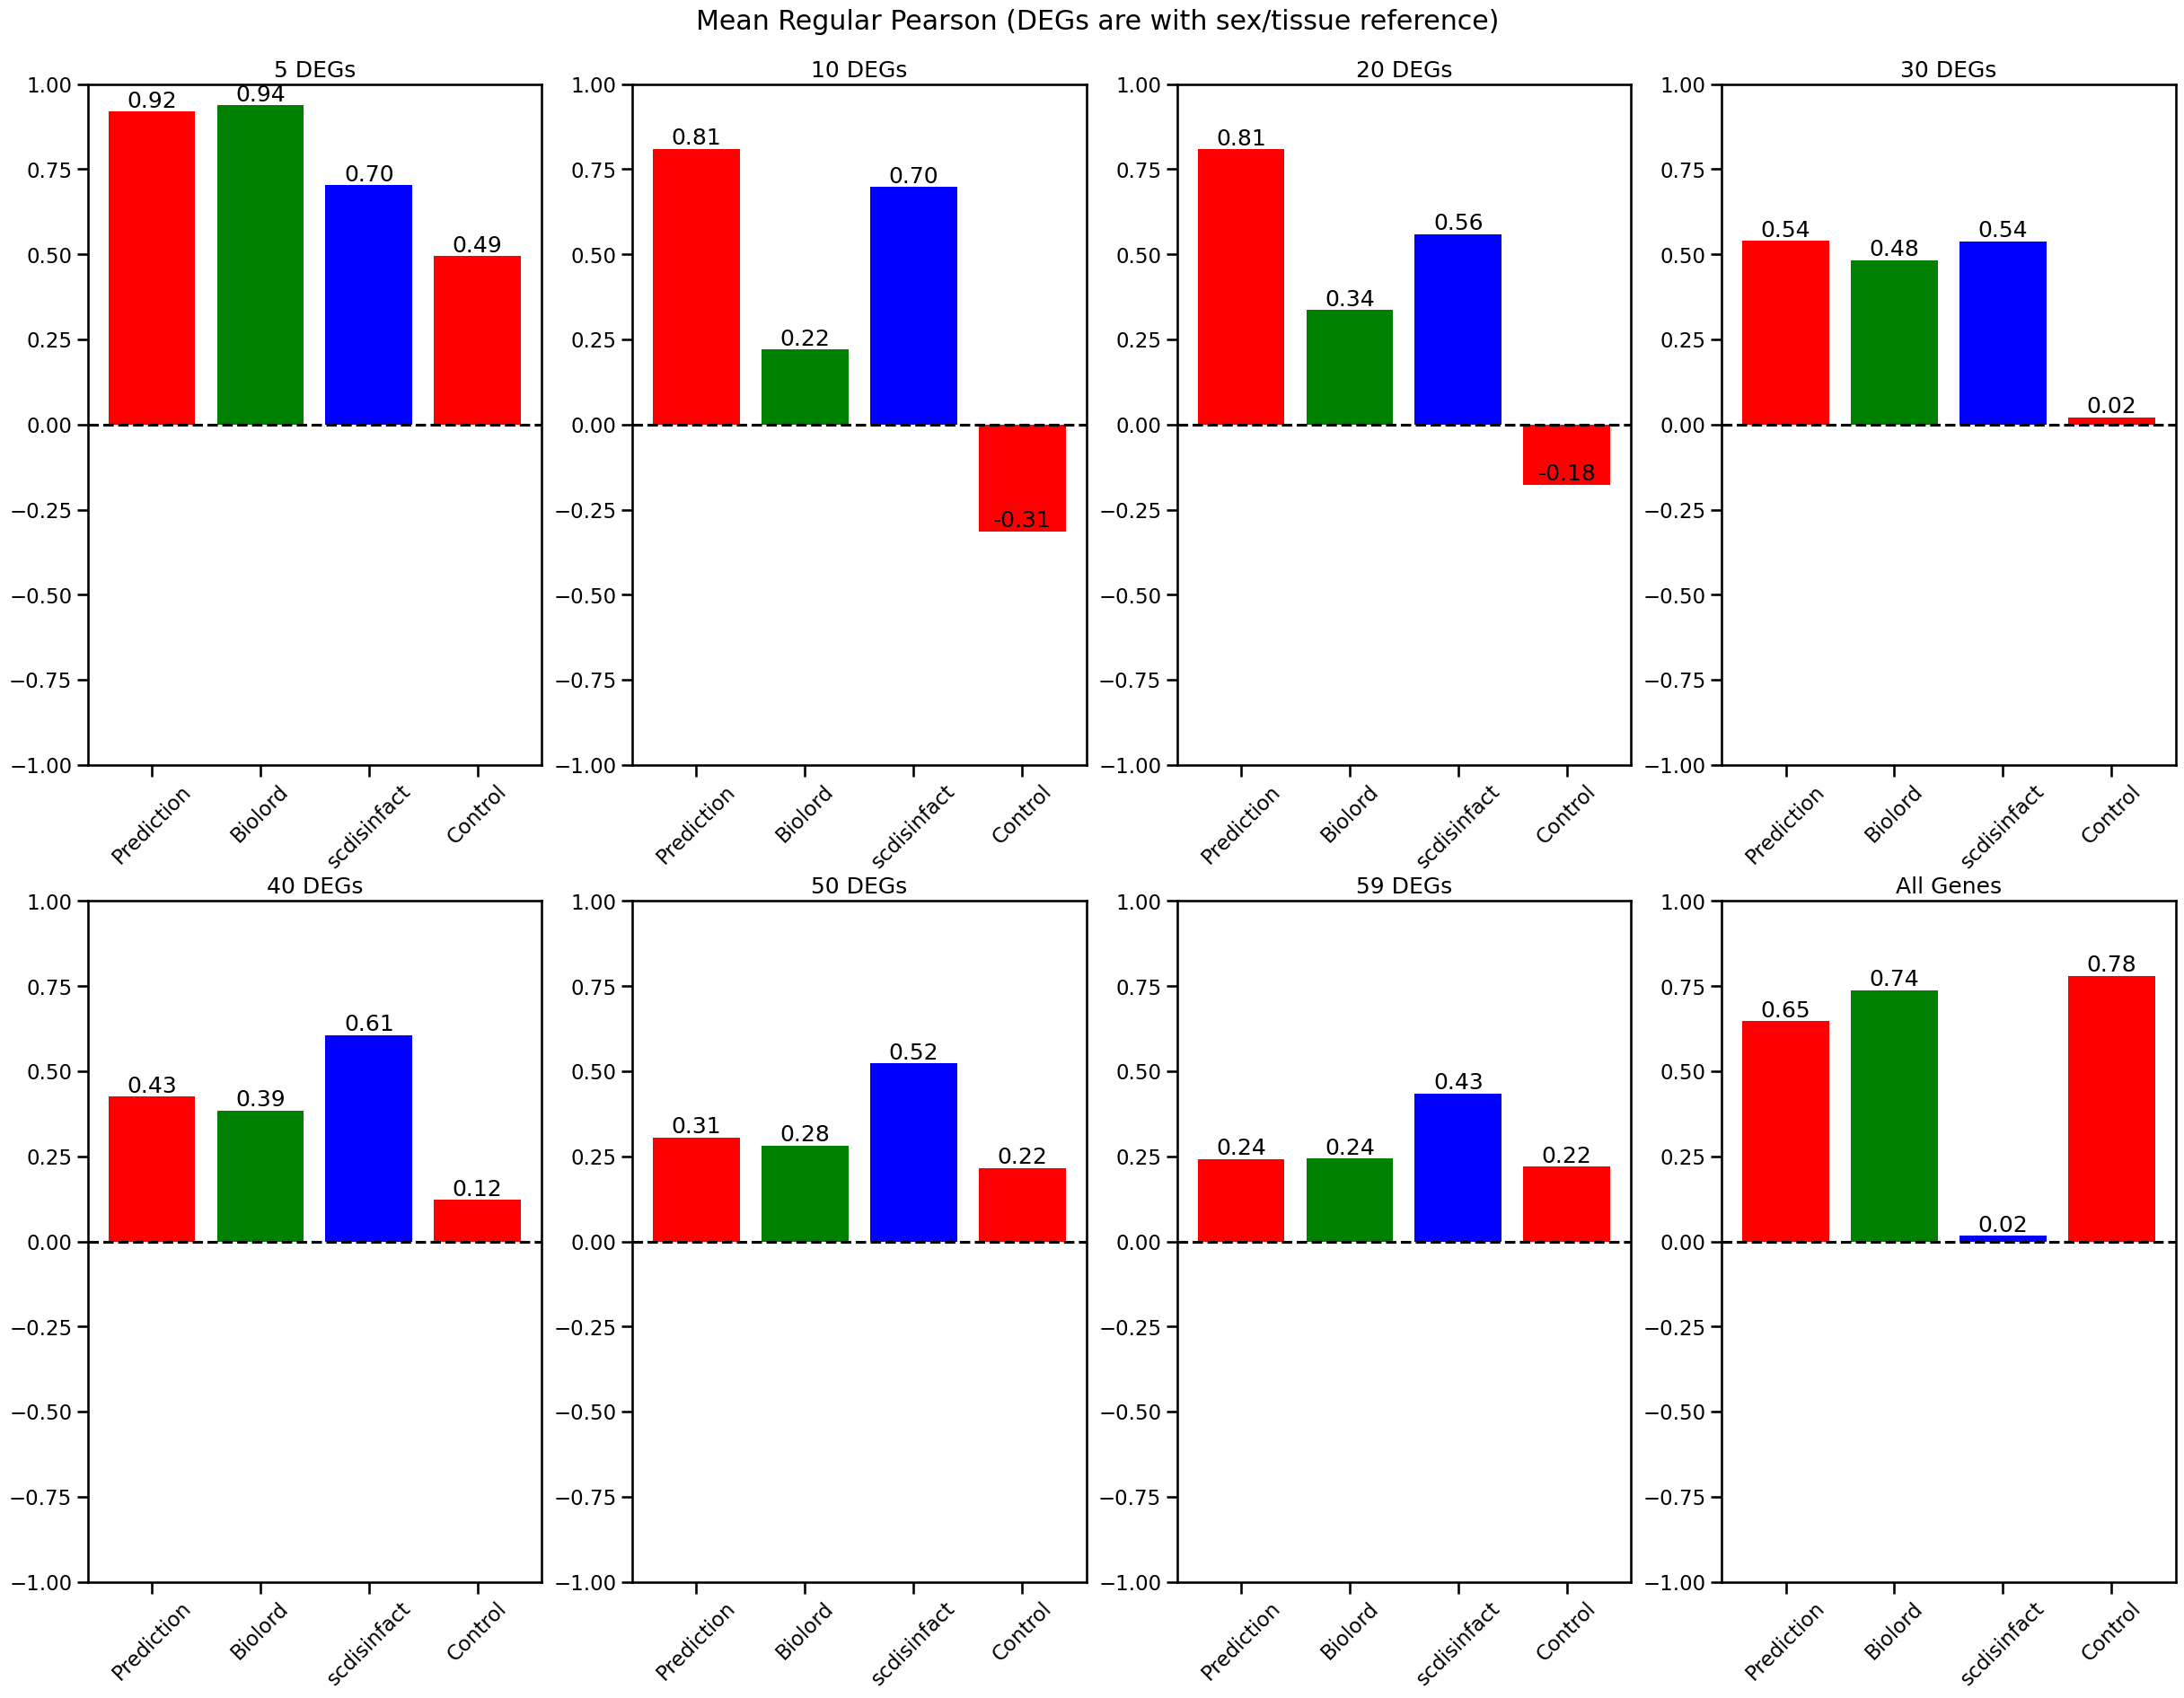

In [37]:
n_rows = r2_results.shape[0]
df = r2_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][:4]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[:4], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
fig.suptitle('Mean Regular Pearson (DEGs are with sex/tissue reference)', y = 1.57)
# plt.title("Mu Regular Pearson")
plt.subplots_adjust(top=1.5)
plt.show()  # Displaying the plot

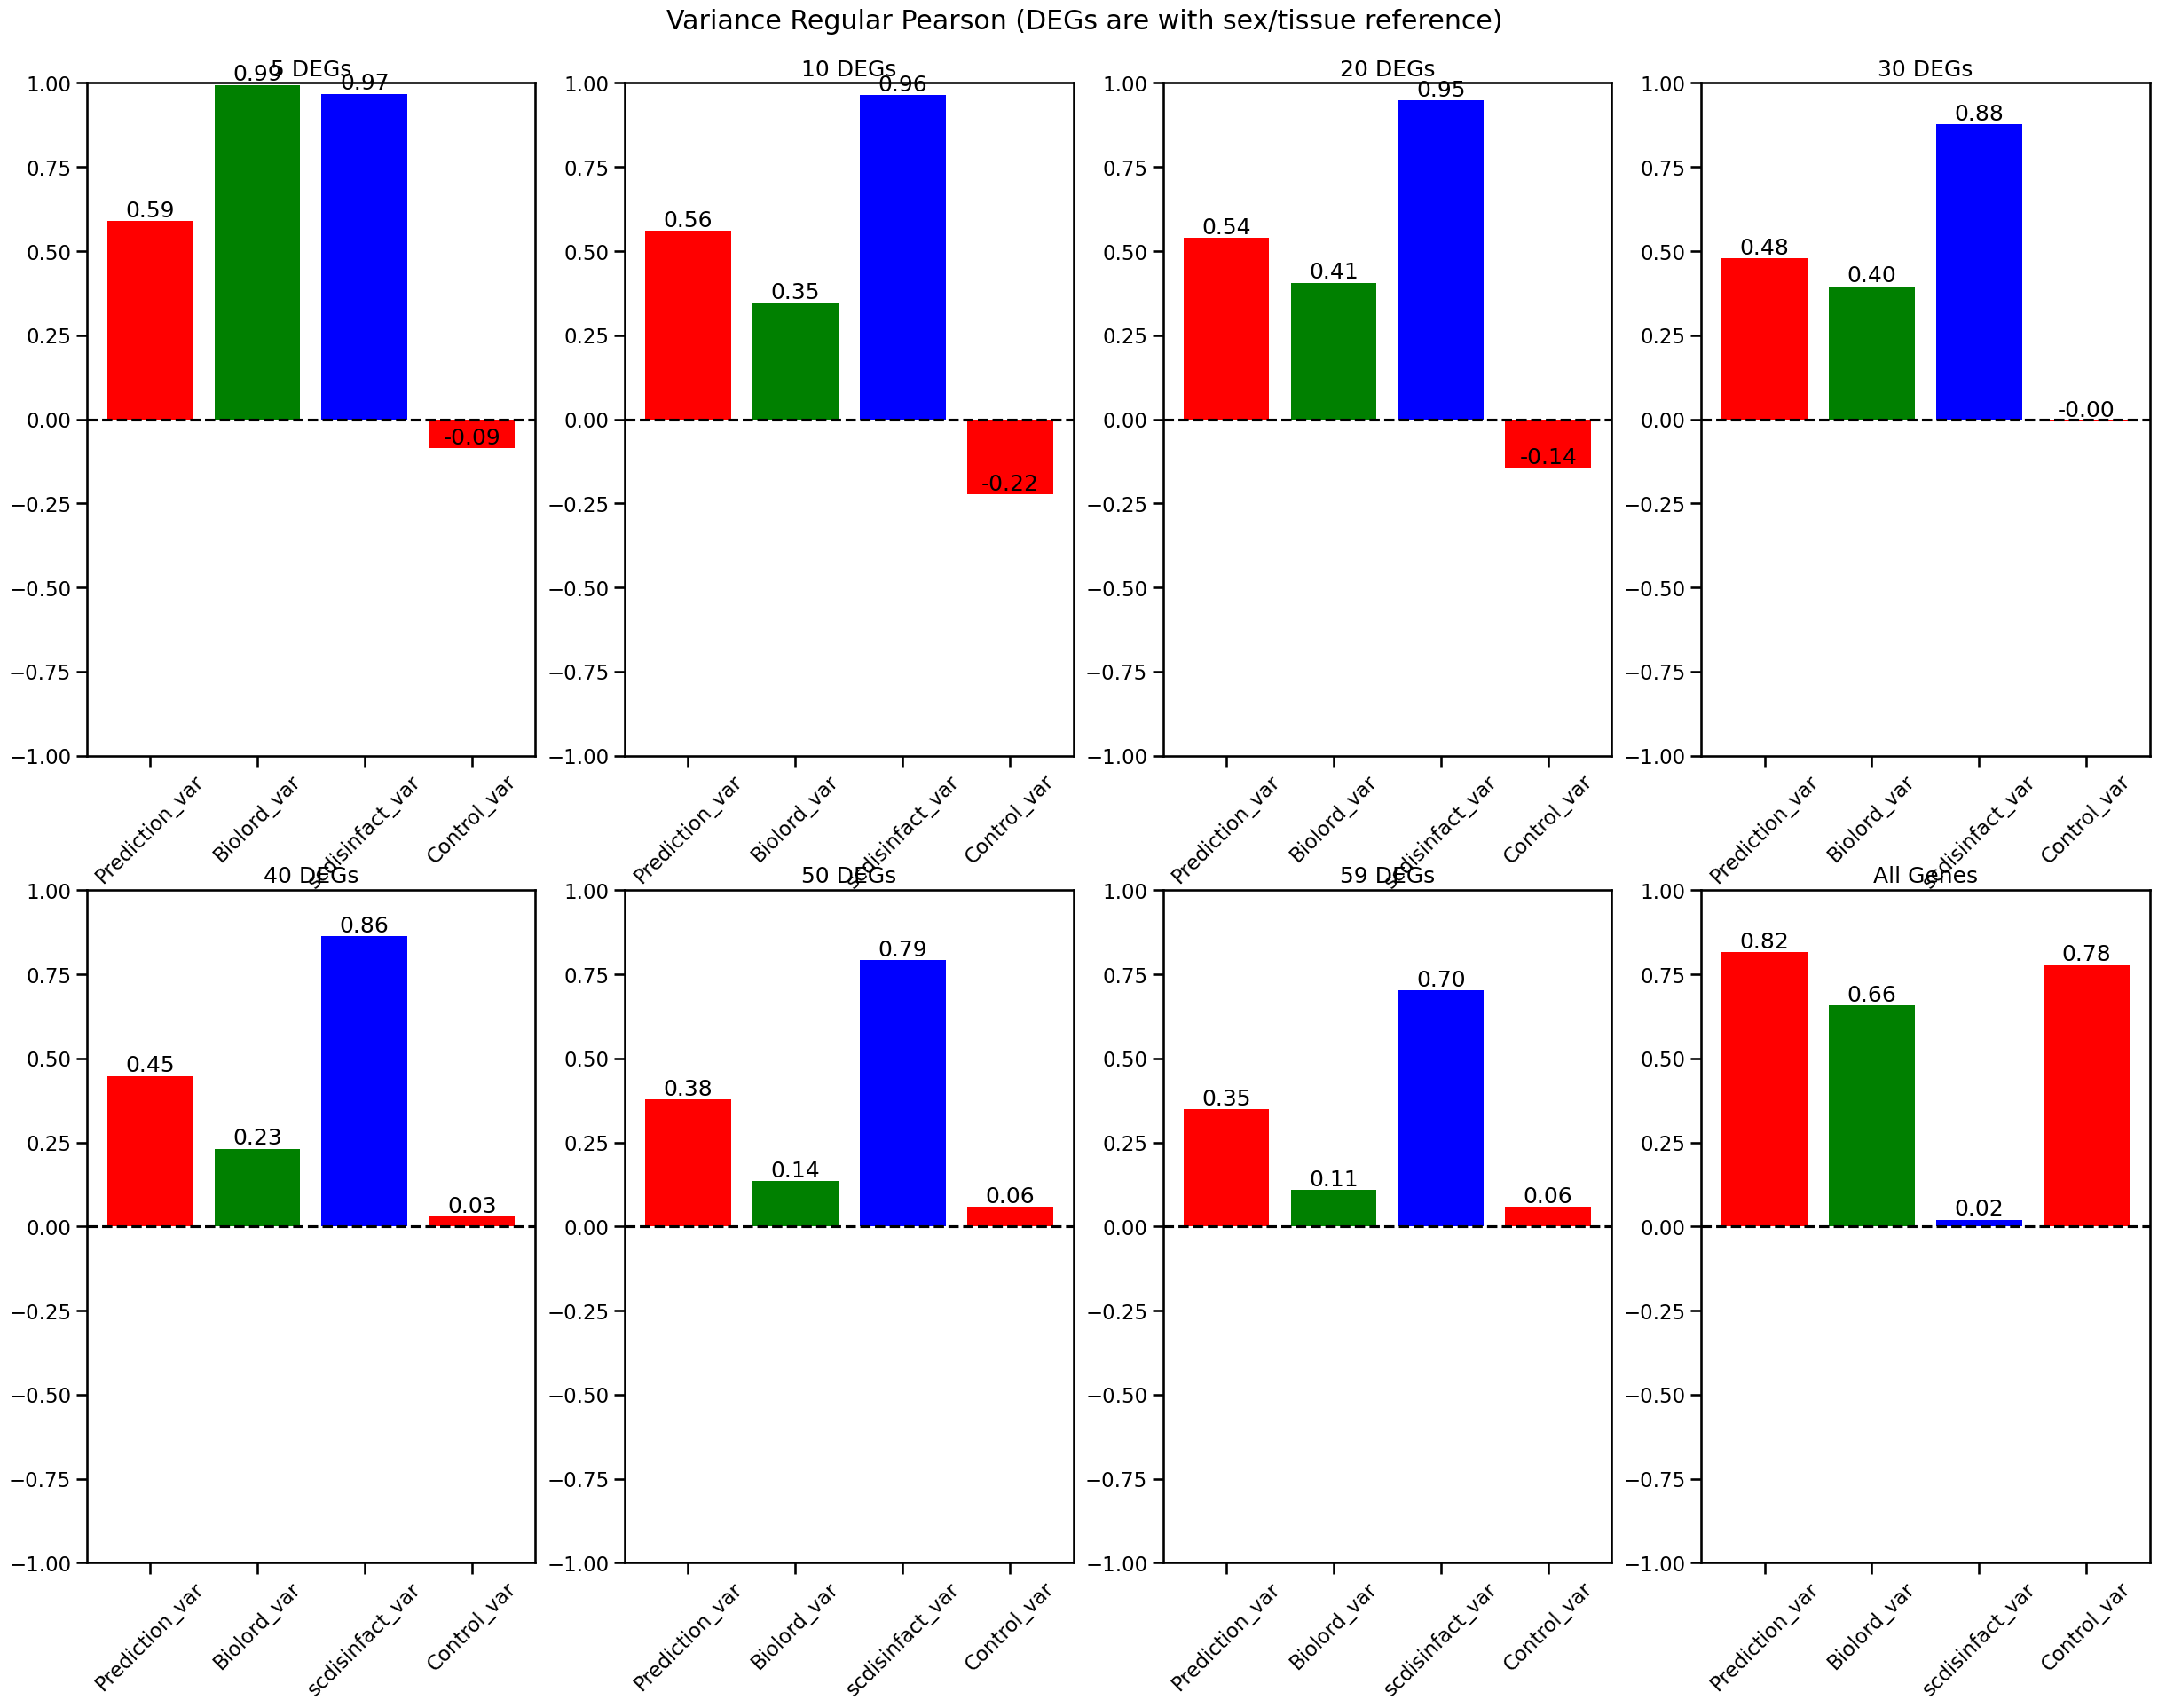

In [38]:
n_rows = r2_results.shape[0]
df = r2_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][4:]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[4:], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
fig.suptitle('Variance Regular Pearson (DEGs are with sex/tissue reference)', y = 1.57)
# plt.title("Mu Regular Pearson")
plt.subplots_adjust(top=1.5)
plt.show()  # Displaying the plot

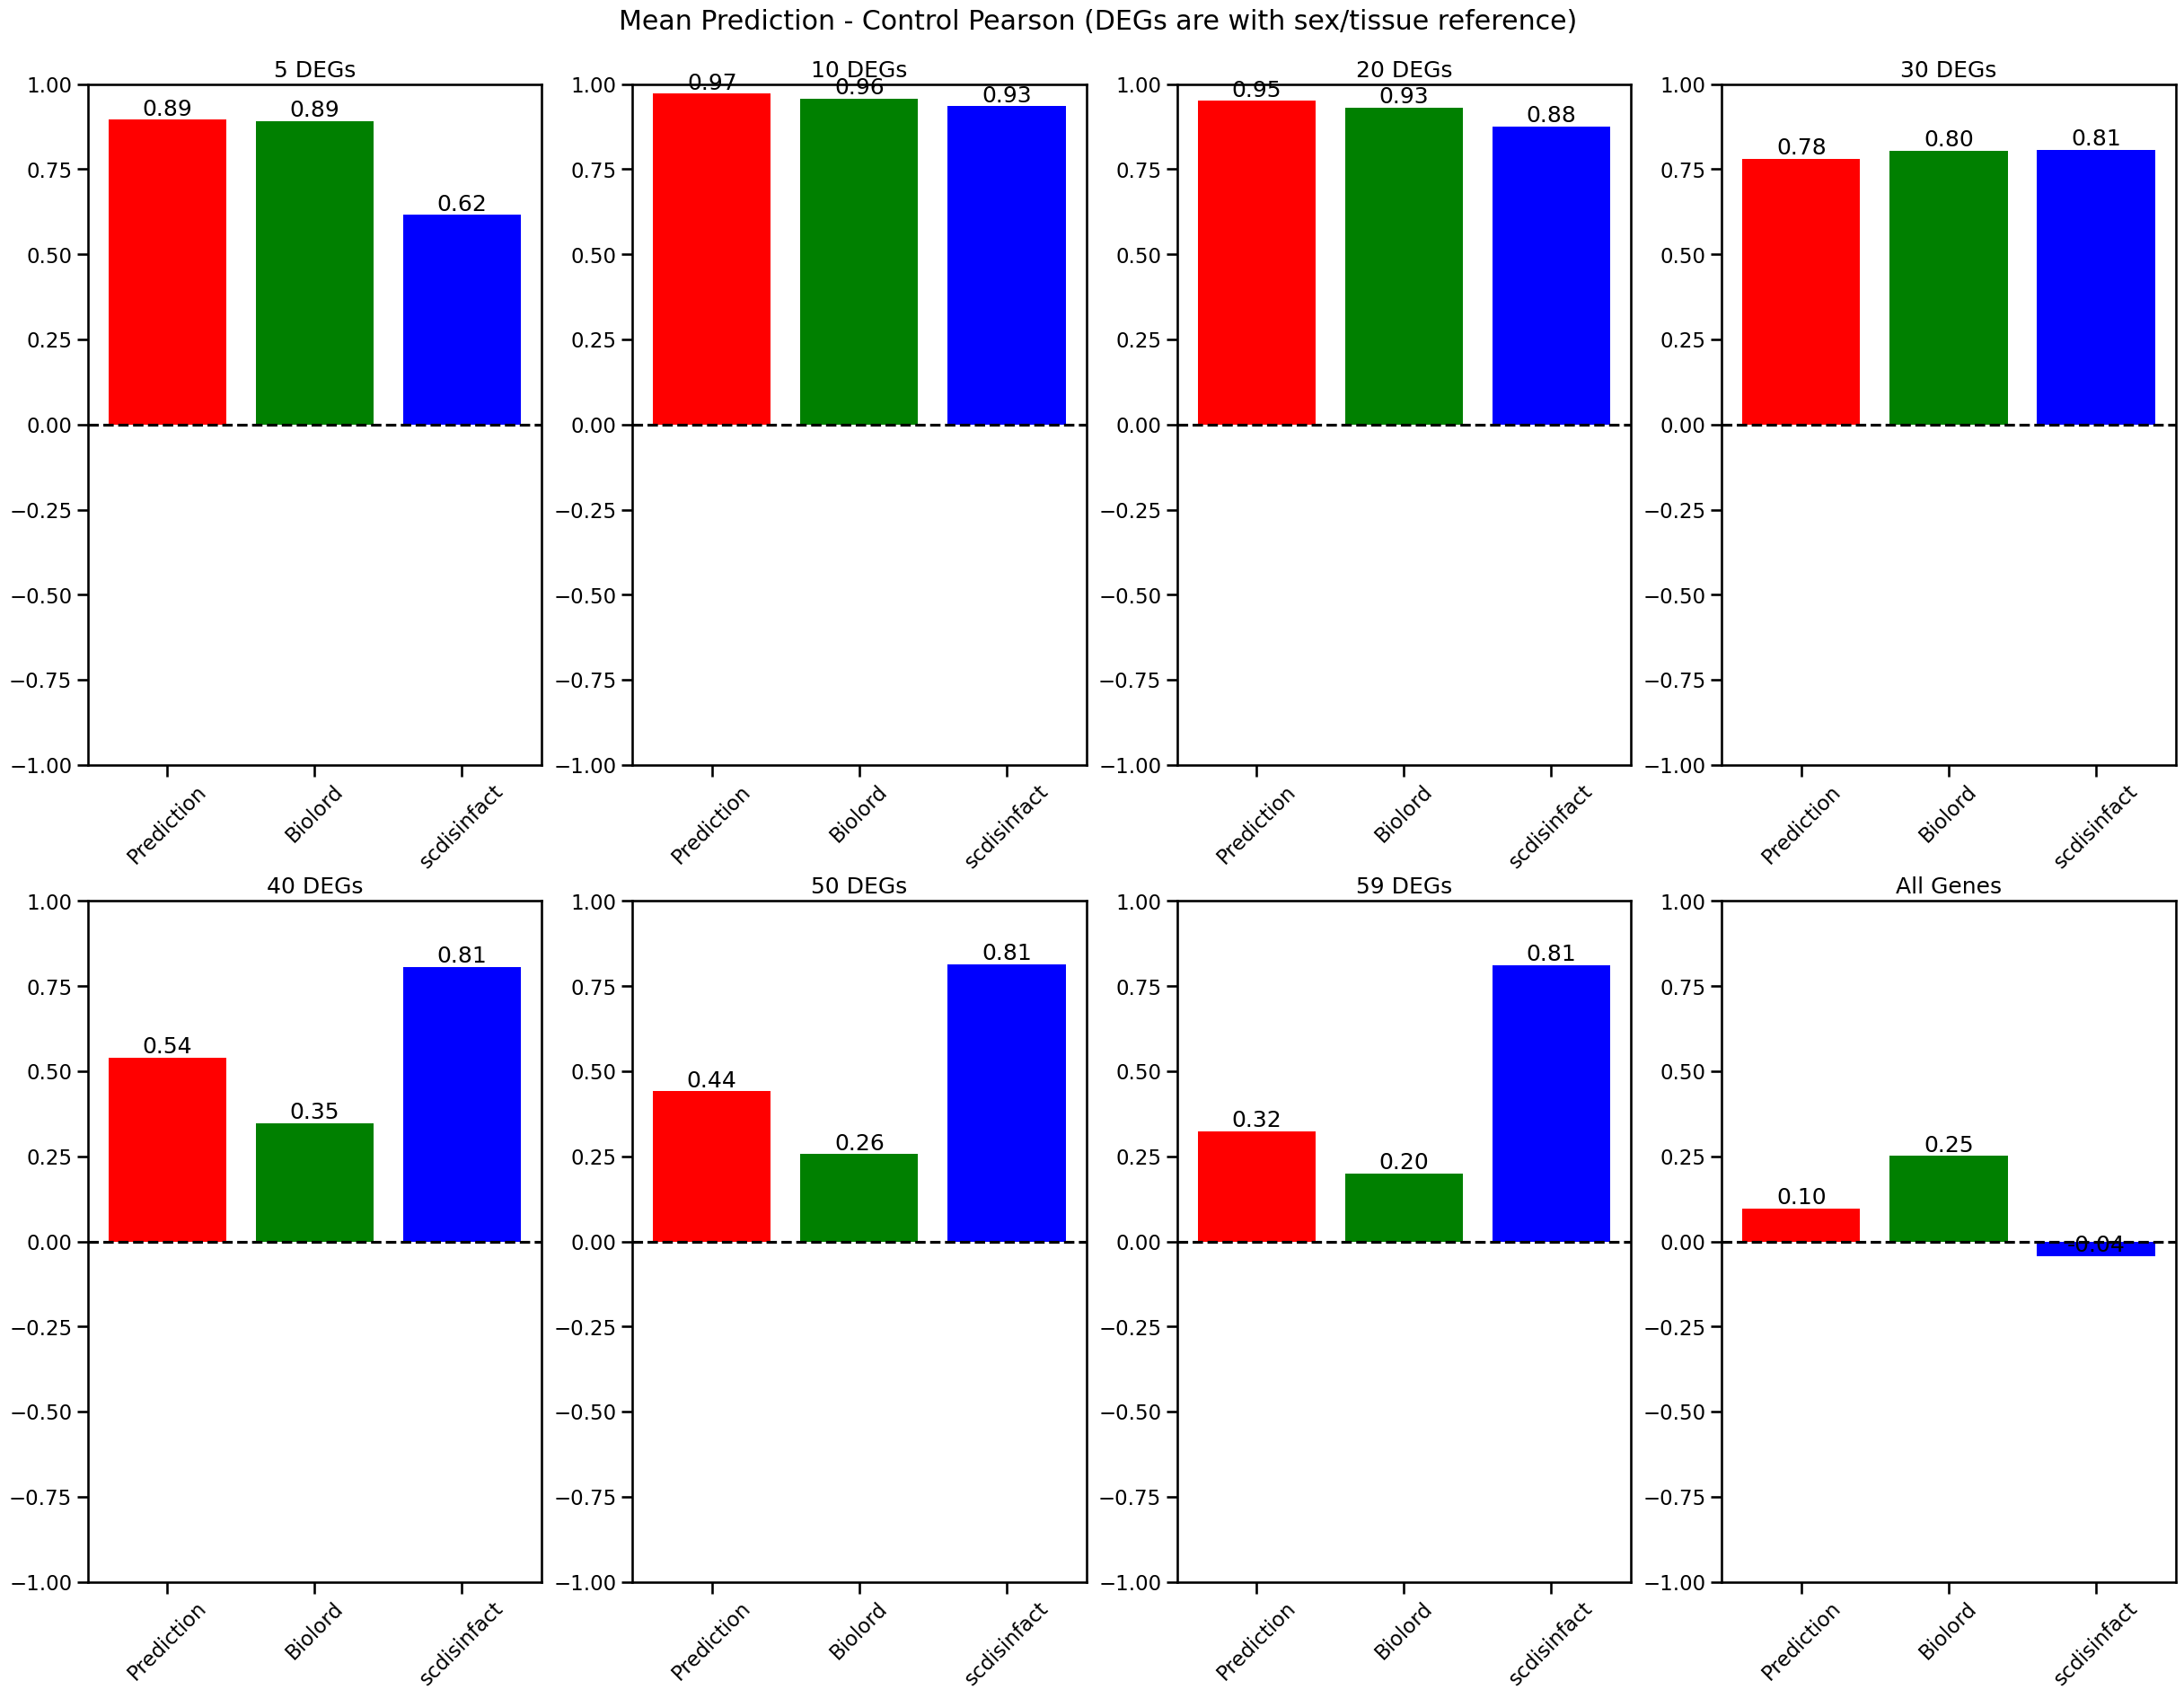

In [39]:
n_rows = r2_results_subtract.shape[0]
df = r2_results_subtract
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][:3]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[:3], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
fig.suptitle('Mean Prediction - Control Pearson (DEGs are with sex/tissue reference)', y = 1.57)
plt.subplots_adjust(top=1.5)

plt.show()  # Displaying the plot

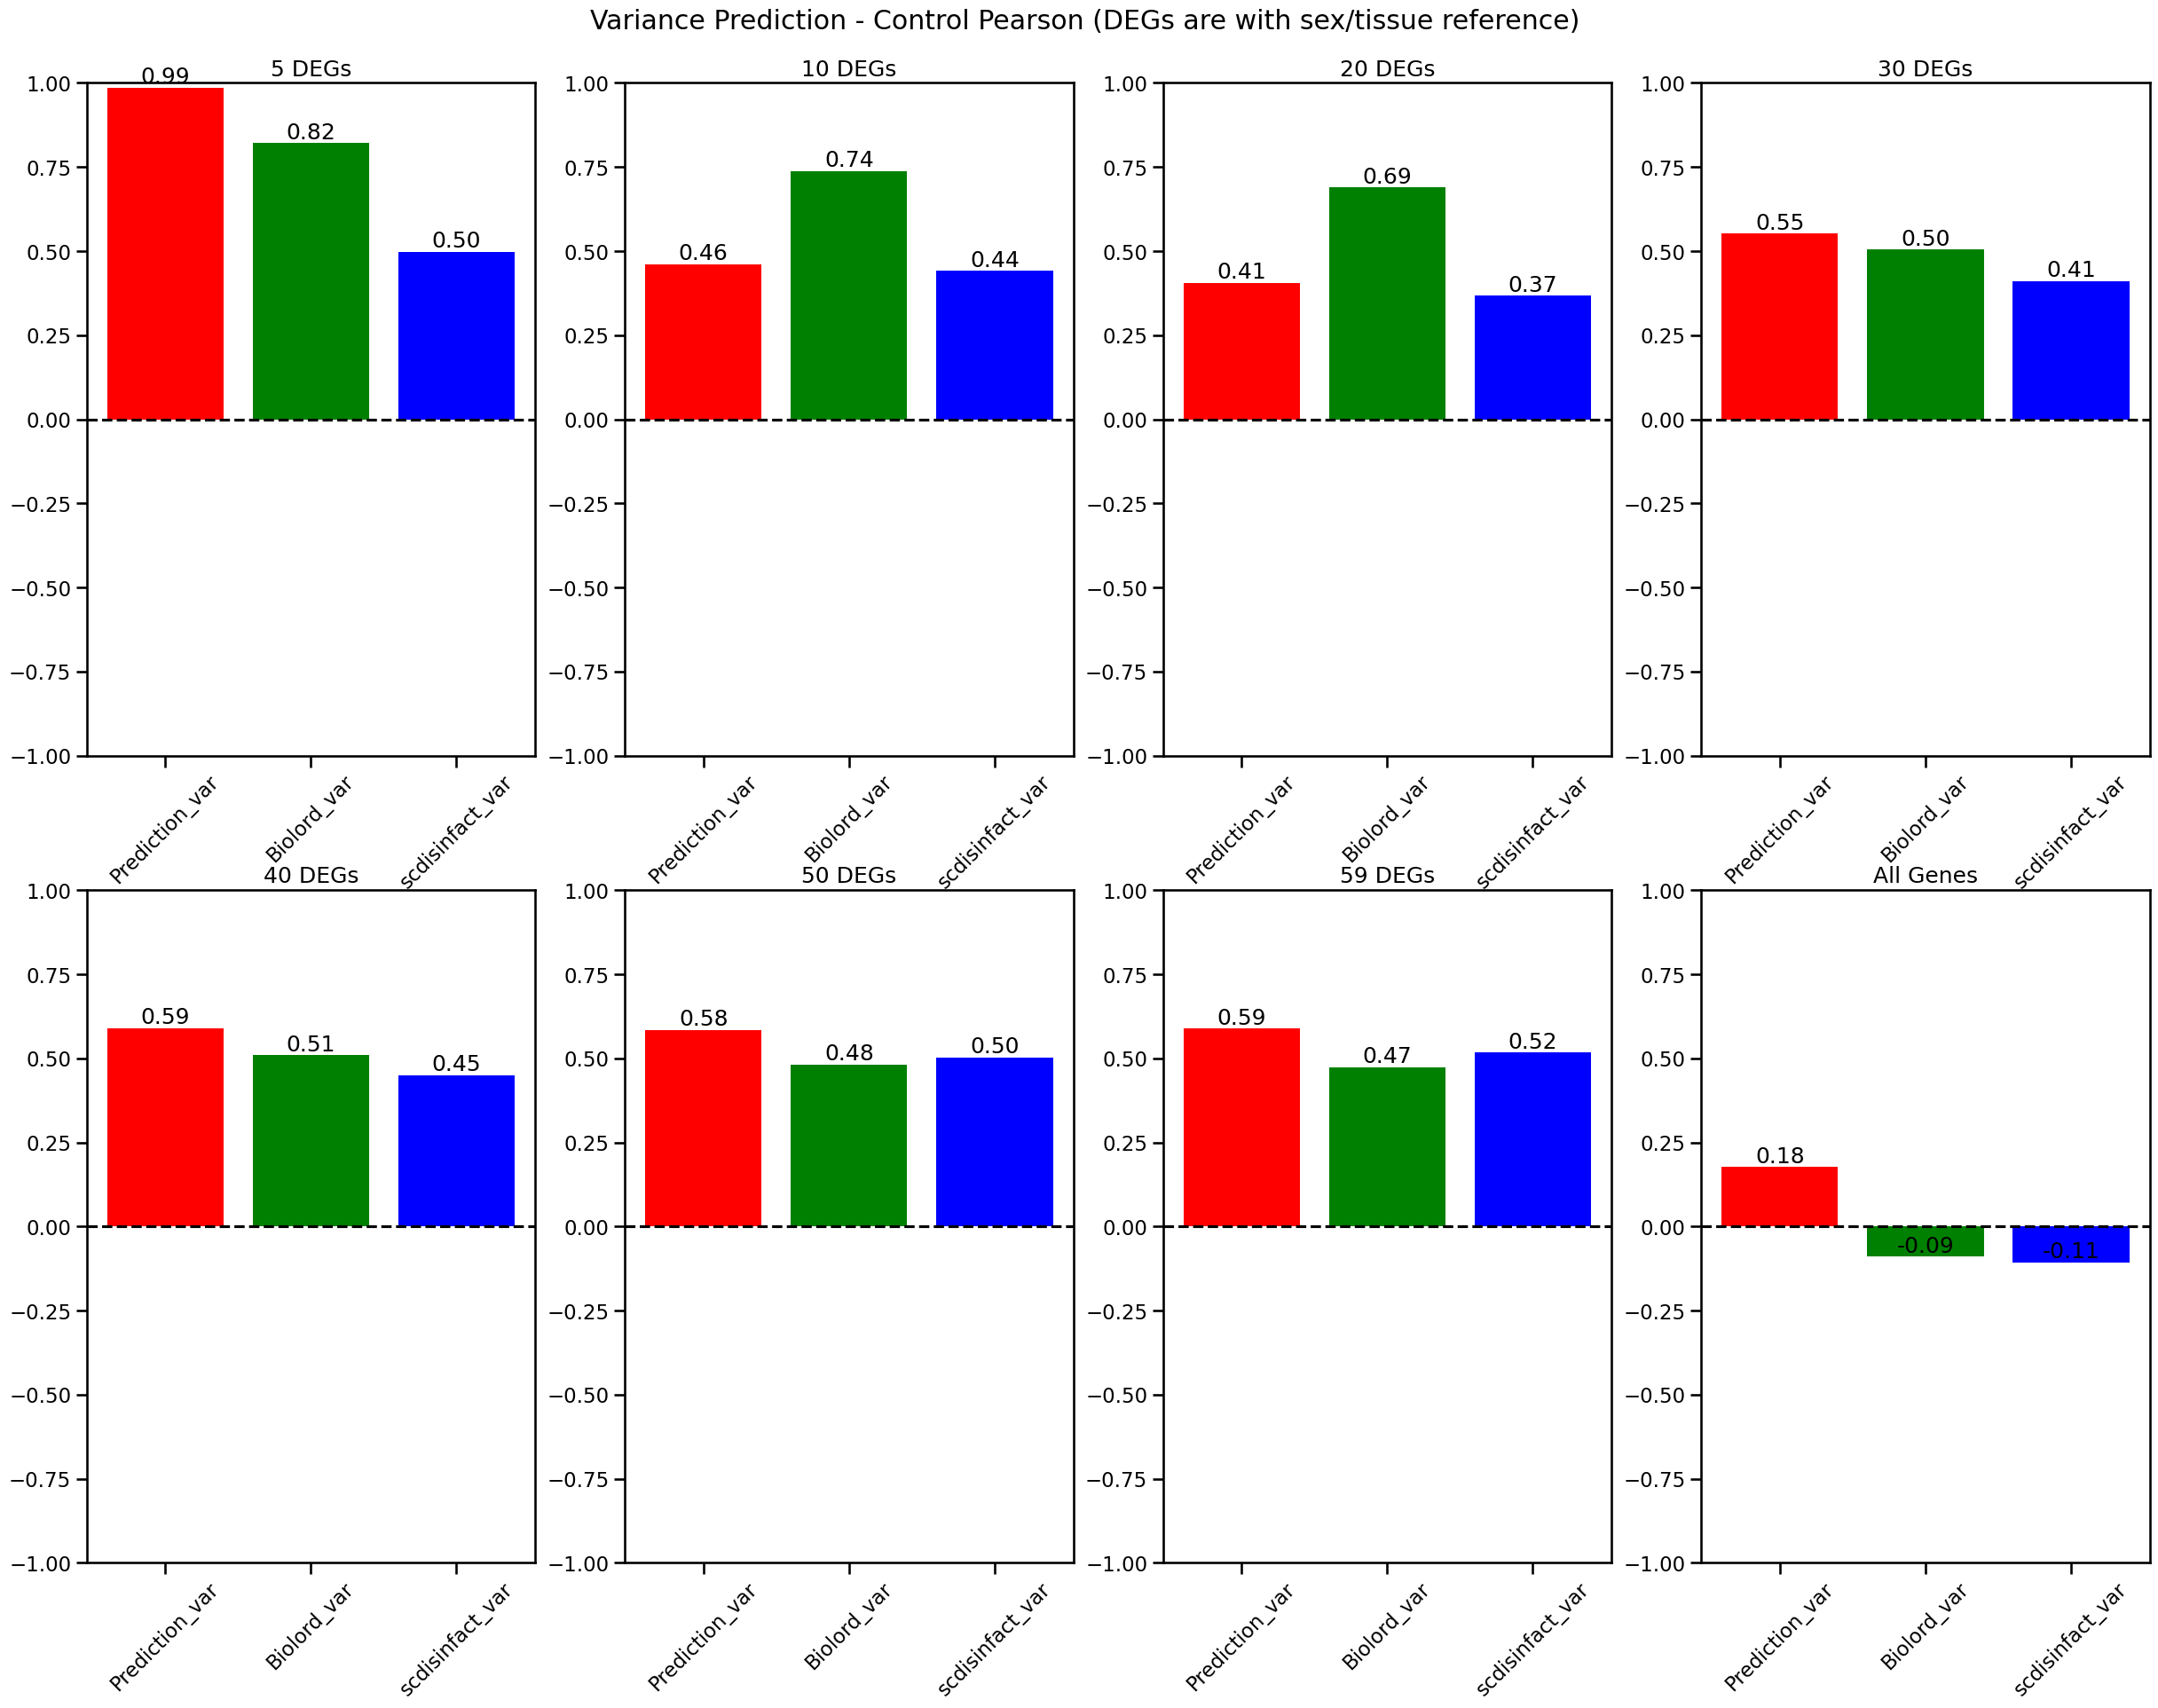

In [40]:
n_rows = r2_results_subtract.shape[0]
df = r2_results_subtract
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][3:]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[3:], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
fig.suptitle('Variance Prediction - Control Pearson (DEGs are with sex/tissue reference)', y = 1.57)
plt.subplots_adjust(top=1.5)

plt.show()  # Displaying the plot

         Falling back to preprocessing with `sc.pp.pca` and default params.


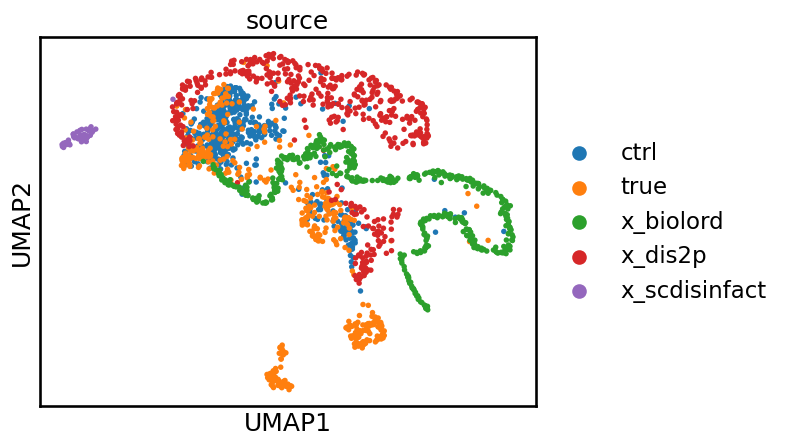

In [41]:
obs = ['ctrl']*x_ctrl.shape[0] + ['true']*x_true.shape[0] + ['x_dis2p']*x_pred.shape[0] + ['x_biolord']*x_biolord.shape[0] + ['x_scdisinfact']*x_scdisinfact.shape[0]
from anndata import AnnData
results_adata = AnnData(X=torch.concat([x_ctrl, x_true, x_pred, x_biolord, x_scdisinfact]).numpy(),
                        obs={'source': obs})
sc.pp.neighbors(results_adata)
sc.tl.umap(results_adata)
sc.pl.umap(results_adata, color='source')

In [27]:
# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    # adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
random.seed(0)

cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']

nrow = len(cats) + 1
ncol = len(cats)

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
        legend_loc=None,
        # ax=axs[i][:]
    )

In [ ]:
import warnings
warnings.filterwarnings("ignore")

cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']

nrow = len(cats) + 1
ncol = len(cats)

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color='Broad cell type',
        # ncols=len(cats),
        frameon=False,
        # ax=axs[i][:]
    )

In [42]:
test = adata[adata.obs['split_1'] == 'test']

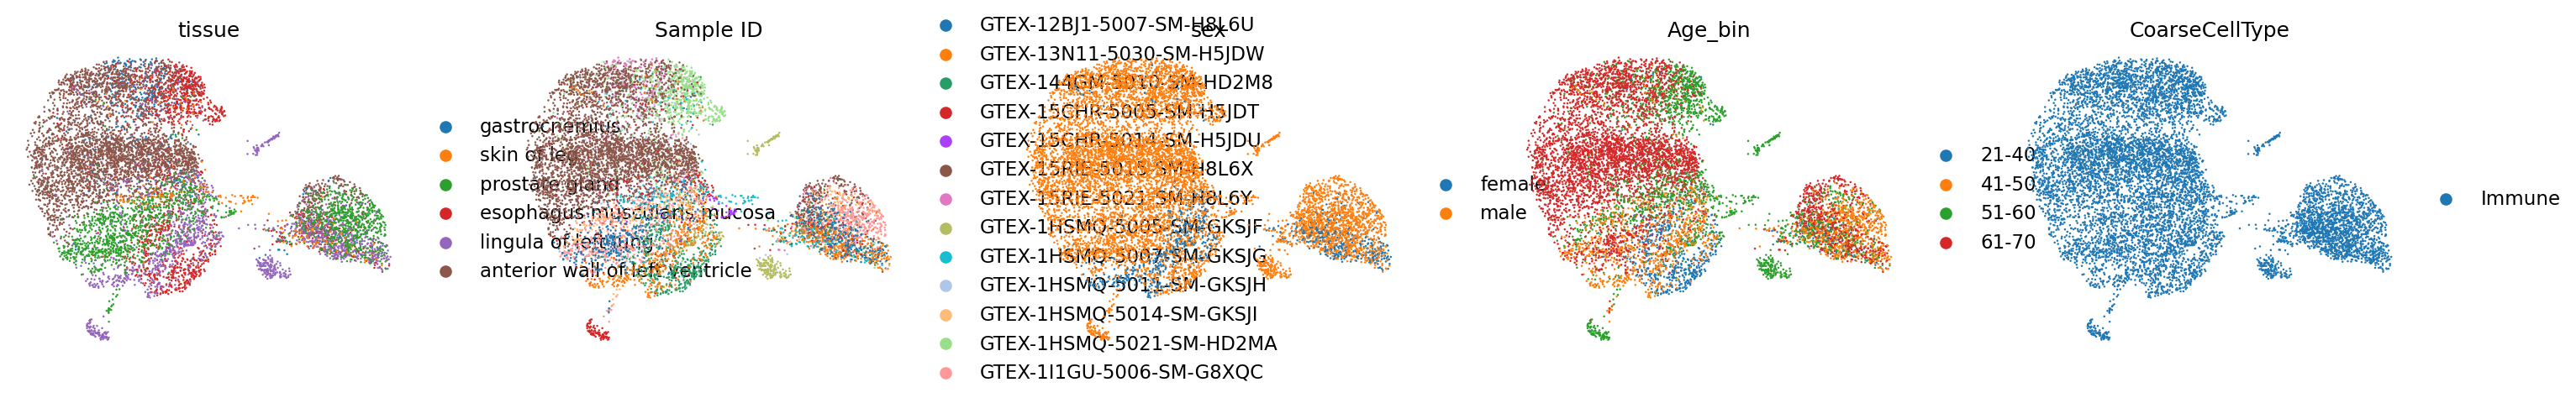

In [43]:
sc.pp.neighbors(test)
sc.tl.umap(test)

sc.pl.umap(
    test,
    color=cats,
    ncols=len(cats),
    frameon=False,
    # ax=axs[i][:]
)

In [44]:
obs = ['ctrl']*x_ctrl.shape[0] + ['true']*x_true.shape[0] + ['x_dis2p']*x_pred.shape[0] + ['x_biolord']*x_biolord.shape[0] + ['x_scdisinfact']*x_scdisinfact.shape[0]
from anndata import AnnData
results_adata = AnnData(X=torch.concat([x_ctrl, x_true, x_pred, x_biolord, x_scdisinfact]).numpy(),
                        obs={'source': obs},
                        var=adata.var)

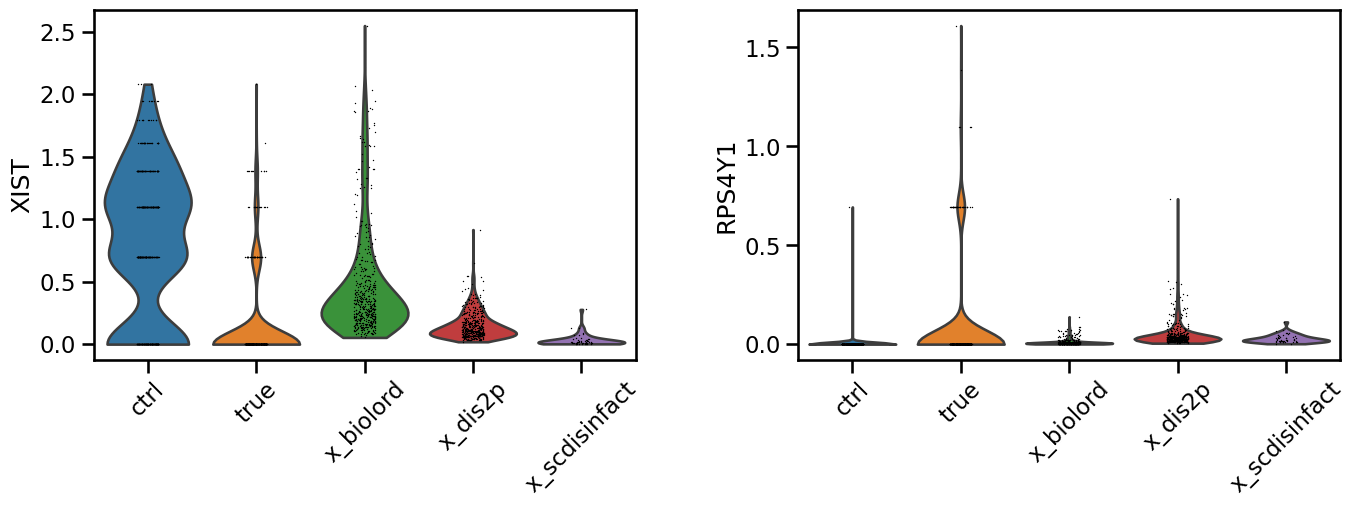

In [45]:
sc.pl.violin(results_adata, ['XIST', 'RPS4Y1'], groupby='source', rotation=45)